# 분산분석(ANOVA)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## 개념
- 두 개 이상의 집단에서 그룹 평균 간 차이를 그룹 내 변동에 비교하여 살펴보는 데이터 분석 방법이다.
- 두 개 이상 집단들의 평균 간 차이에 대한 통계적 유의성을 검증하는 방법

## 1. 일원배치 분산 분석(One-way ANOVA)

### 1) 특징
- 하나의 범주형 변수의 영향을 알아보기 위해 사용되는 검증방법
- 모집단 수 제한X, 각 표본 수 일치 안해도 된다.
- F 통계량 사용

### 2) 가정
- 정규성(각 집단 서로 독립적 + 정규분포 따른다.)
- 등분산성

### 3) 가설검정
- 귀무가설 : 집단 간 모평균에는 차이가 없다
- 대립가설 : 집단 간 모평균이 모두 같다고 할 수 없다.

### 4) 사후검정
- 귀무가설이 기각되어 적어도 한 집단에서 평균의 차이가 있음이 통계저긍로 증명되었을 경우, 어떤 집단들에 대해서 평균의 차이가 존재하는지를 알아보기 위한 방법(Fisher, MRT, LSD, HSD, Scheffe)

### 5) 예제

In [3]:
from sklearn.datasets import load_iris

In [53]:
iris = pd.DataFrame(load_iris()['data'],columns=load_iris()['feature_names'])

In [54]:
iris['target']  =load_iris()['target']

In [55]:
target_names = load_iris()['target_names']

In [56]:
iris['target'] = iris['target'].apply(lambda x : target_names[x])

In [62]:
col_list = ["_".join(col.split(' ')[:-1]) for col in iris.columns[:-1]]
col_list.append('target')

In [64]:
iris.columns = col_list

#### 정규성 검정

In [88]:
for value in  iris.target.unique() :
    print("{} : {}".format(value,scipy.stats.shapiro(iris.sepal_width[iris.target==value])))

setosa : ShapiroResult(statistic=0.97171950340271, pvalue=0.2715264856815338)
versicolor : ShapiroResult(statistic=0.9741330742835999, pvalue=0.33798879384994507)
virginica : ShapiroResult(statistic=0.9673910140991211, pvalue=0.1809043288230896)


- 모두 pvalue 값이 유의수준보다 크므로 귀무가설을 채택하고 정규성을 만족한다고 할 수 있다.

#### 등분산성 검정

In [91]:
scipy.stats.levene(
    iris.sepal_width[iris.target == 'setosa'],
    iris.sepal_width[iris.target == 'versicolor'],
    iris.sepal_width[iris.target == 'virginica'] )

LeveneResult(statistic=0.5902115655853319, pvalue=0.5555178984739075)

In [92]:
scipy.stats.bartlett(
    iris.sepal_width[iris.target == 'setosa'],
    iris.sepal_width[iris.target == 'versicolor'],
    iris.sepal_width[iris.target == 'virginica'] )

BartlettResult(statistic=2.0910752014391774, pvalue=0.35150280041581317)

- 둘 다 유의수준보다 값이 크므로 등분산성을 만족한다고 할 수 있다.

In [66]:
model = ols('sepal_width ~ C(target)',iris).fit()

In [67]:
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(target),2.0,11.344933,5.672467,49.16004,4.492017e-17
Residual,147.0,16.962000,0.115388,NaN,NaN


- SSA(집단이 가지는 변동제곱합)의 자유도는 2(집단의 수 - 1), SST(관측치 값이 가지는 변동제곱합)의 자유도는 147(관측값의 수 - 집단의 수)임을 확인할 수 있다.


- 분석결과 P-Value(PR(>F)) 값이 매우 작게 나와 귀무가설을 기각한다. 세가지 종에 따른 꽃받침 폭이 모두 동일하지 않다는 것이 결론. 즉, 종별 꽃받침 폭의 평균값들 중에서 적어도 어느 하나의 종은 통계적으로 유의한 차이가 있는 값을 가진다는 소리이다.

In [69]:
pairwise_tukeyhsd(iris['sepal_width'],iris['target'],alpha= 0.05).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
setosa,versicolor,-0.658,0.001,-0.8189,-0.4971,True
setosa,virginica,-0.454,0.001,-0.6149,-0.2931,True
versicolor,virginica,0.204,0.0088,0.0431,0.3649,True


- 사후분석에서 귀무가설은 집단들 사의 평균이 같다. 대립가설은 집단들 사이의 평균이 같지 않다를 두고 두 집단씩 짝 지어 각각 다중비교를 수행함

- 3가지 비교에 대해서 p-value(p-adj) 값이 귀무가설을 기각하므로 모든 종들에 대해서 꽃받침 폭의 평균값은 각각 통계적으로 유의한 차이가 있다는 것을 알 수 있다.
- meandiff의 경우 두 집단 간 반응값 차이를 알려주는 것이다. setosa - versicolor의 경우 diff값이 음수이므로 setosa보다 versicolor가 통계적으로 유의하게 큰 값을 가진다고 해석할 수 있다.

- 특징 : 비교 대상 표본수가 동일한 경우에만 사용가능, 모든 집단 조합에 대해 분석
- 장점 : 표본수가 동일한 경우 가장 많이 사용되는 사후 검정 기법
- 단점 : 표본수가 동일해야하고, 표본수가 적을수록 정확도 낮아진다

- 집단별 표본수&분산이 동일한 경우 자주 사용

In [73]:
comp = MultiComparison(iris['sepal_width'], iris['target'])

In [84]:
comp.allpairtest(scipy.stats.ttest_ind,method = 'bonf')[0]

group1,group2,stat,pval,pval_corr,reject
setosa,versicolor,9.455,0.0,0.0,True
setosa,virginica,6.4503,0.0,0.0,True
versicolor,virginica,-3.2058,0.0018,0.0055,True


- 3가지 경우 다 귀무가설 기각하므로 3가지 경우 다 평균 차이가 유의미하다
- 특징 : 응용범위가 넓다(모수, 비모수),Turkey보다 엄격하지만, scheffe보다 관대
- 장점 : 각 cell의 크기가 다르더라도 사용가능
- 단점 : 필요이상으로 넓은 신뢰구간 제시, 비교대상이 많을수록 검정력 약해진다.

In [49]:
import scikit_posthocs as sp

In [101]:
sp.posthoc_scheffe(iris,val_col='sepal_width',group_col='target',p_adjust = 'holm').

,setosa,versicolor,virginica
setosa,1.000000e+00,1.758878e-16,3.405790e-09
versicolor,1.758878e-16,1.000000e+00,1.258285e-02
virginica,3.405790e-09,1.258285e-02,1.000000e+00


- 값들은 서로에 대한 pvalue이다. 그래서 pvalue를 보면 다 유의수준보다 낮으므로 귀무가설을 기각한다. 즉, 서로 간의 평균 차이가 있다

## 2. 이원배치 분산 분석(Two-way ANOVA)

- 반응값에 대해 2개의 범주형 변수 A,B의 영향을 알아보기 위해 사용되는 검증 방법
- ex) 성별과 학년에 따른 시험점수의 차이에 대한 통계적으로 검정하기 위해 사용
- A,B가 상관관계가 있는지를 살펴보는 교호작용에 대한 검증이 반드시 진행된다.

### 1) 가정

- 정규성, 등분산성

### 2) 가설검정

- **귀무가설 :** 변수에 따른 종속변수 값에는 차이가 없다.(A1 = A2 = An = 0) 변수에 따른 종속변수 값에는 차이가 없다.(B1= B2 = Bn = 0), a와 b 변수의 상호작용 효과가 없다.

- **대립가설 :** 변수에 따른 종속변수 값에 차이가 있다.(ai가 모두 0이라고 할 수 없다) 변수에 따른 종속변수 값에 차이가 있다(b1 모두 0이라고 할 수 없다.) a와 b변수의 상호작용 효과가 있다.


### 3) 교호작용
- 2가지 이상의 특정 변수 조합에서 일어나는 효과(상관관계 존재 -> 교호작용이 있다는 의미)
- 교호작용이 없을 경우는 주효과 검정 실시, 있으면 검정이 무의미하다

In [5]:
gender = ['M'] * 9 + ['F'] *9

In [9]:
class_list = ['class1'] * 3 + ['class2'] * 3 + ['class3'] * 3 + ['class1'] * 3 + ['class2'] * 3 + ['class3'] * 3

In [12]:
df = pd.DataFrame({'gender' : gender,'class' : class_list})

In [15]:
df['score'] = [71, 77, 78, 76, 77, 78, 71, 70, 69, 80, 76, 80, 79, 78, 77, 73, 71, 70]

In [17]:
import seaborn as sns

<AxesSubplot:xlabel='gender', ylabel='score'>

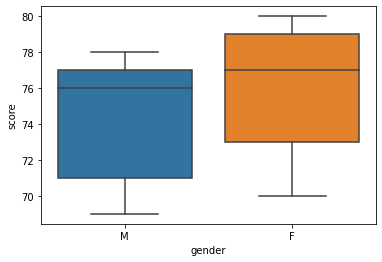

In [19]:
sns.boxplot(x = 'gender',y = 'score',data=df)

<AxesSubplot:xlabel='class', ylabel='score'>

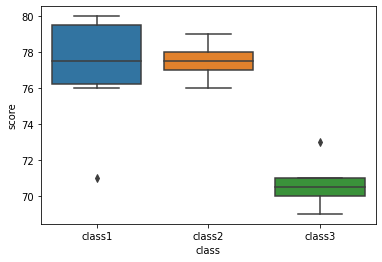

In [20]:
sns.boxplot(x = 'class',y = 'score',data = df)

In [21]:
from statsmodels.graphics.factorplots import interaction_plot

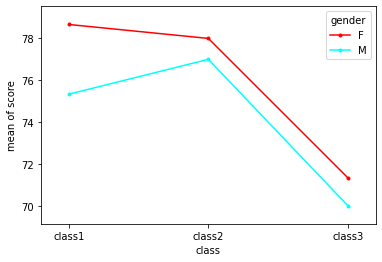

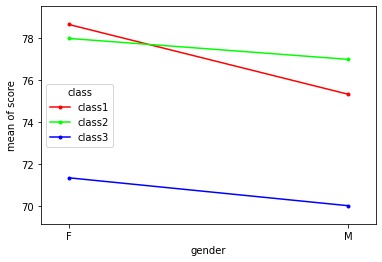

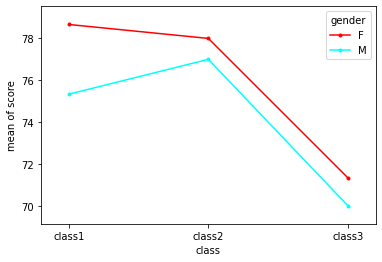

In [32]:
interaction_plot(df['gender'],df['class'],df['score'])
interaction_plot(df['class'],df['gender'],df['score'])

- 서로 교차를 하면 교호작용이 있다고 보면 되며, 서로 평행선을 이룬다면 교호작용이 없다고 해석하면 된다.

In [42]:
df.columns = [col.capitalize() for col in df.columns]

In [44]:
aov = ols('Score ~ C(Gender) + C(Class) + C(Gender):C(Class)',data = df).fit()
print(anova_lm(aov))

                      df      sum_sq    mean_sq          F    PR(>F)
C(Gender)            1.0   16.055556  16.055556   3.853333  0.073249
C(Class)             2.0  174.111111  87.055556  20.893333  0.000123
C(Gender):C(Class)   2.0    4.777778   2.388889   0.573333  0.578354
Residual            12.0   50.000000   4.166667        NaN       NaN


#### 비균형설계자료의 경우 typ=3 옵션을 추가해준다.(anova_lm(typ = 3))

- 교호작용이 있는지를 살펴보면, 3번째(C(Gender):C(Class))의 P-value가 0.57834로서 유의수준 0.05보다 크므로 귀무가설을 채택하게 된다. 그래서 둘 간에는 교호작용에 의한 효과는 없다고 판단할 수 있다.


- C(Gender) 성별요인의 경우 P-value가 유의수준보다 크므로 귀무가설 채택하게 된다. 즉, 성별에 따른 통계적 차이가 없다고 할 수 있다.


- C(Class)의 경우 유의수준보다 작으므로 귀무가설을 기각하게 된다. 그러므로 class에 따른 통계학 차이가 있다고 할 수 있다.

In [48]:
pairwise_tukeyhsd(df['Score'],df['Class'],alpha= 0.05).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
class1,class2,0.5,0.9,-2.7576,3.7576,False
class1,class3,-6.3333,0.001,-9.5909,-3.0758,True
class2,class3,-6.8333,0.001,-10.0909,-3.5758,True


- class1과 class2 이 첫 번째 것만 제외하고 두 가지는 귀무가설을 기각하게 된다. 즉, class1과 class3, class2와 class3는 통계적으로 평균값이 유의미한 차이를 보이고 있다고 할 수 있다.

In [52]:
sp.posthoc_scheffe(df,val_col='Score',group_col='Class',p_adjust = 'holm')

,class1,class2,class3
class1,1.000000,0.924045,0.000584
class2,0.924045,1.000000,0.000279
class3,0.000584,0.000279,1.000000


class1 & class3, class2&class3 의 경우 귀무가설을 기각하므로 서로 간의 평균 차이가 있다.

## 3. 교차분석

### 1) 개념 및 특징
- 범주형 자료인 두 변수 간의 관계를 알아보기 위해 실시하는 분석 기법.
- 적합도, 독립성, 동일성 검정에 사용
- 카이제곱 검정 통계량 사용한다.

### 2) 적합도 검정

- 관측값들이 예상한 이론과 일치하는지 아닌지 검정하는 방법
- 관측값들이 어떠한 이론적 분포를 따르고 있는지 알아보기 위한 방법
- 모집단 분포에 대한 가정이 옳게 됐는지를 관측 자료와 비교하여 검정하는 것

#### 가설검정
- 귀무가설 : 실제 분포와 이론적 분포 간에는 차이가 없다
- 대립가설 : 차이가 있다.

#### 자유도

- k-1

#### 예제

- 귀무가설 : 전체 응답자 중 왼손잡이는 20%, 오른손잡이는 80%이다.
- 대립가설 : 전체 응답자 중 왼손잡이 20%, 오른손잡이 80%라고 할 수 없다.

In [59]:
survey = pd.read_csv('survey.csv').iloc[:,1:]

In [118]:
predict = [(data['Right'] *0.8).values[0],(data['Left'] * 0.2).values[0]]

In [119]:
value = survey['W.Hnd'].value_counts().tolist()

In [120]:
result =scipy.stats.chisquare(value,predict)

In [121]:
result

Power_divergenceResult(statistic=68.5, pvalue=1.2687760382545653e-16)

- 유의확률이 0.05보다 작으므로 귀무가설을 기각하게 되고 왼손잡이 20%, 오른손잡이 80%라고 할 수 없다.

- 이원카이제곱검정의 경우는 chi2_contingency를 이용한다.

### 3) 독립성 검정

#### 의미

- 두 변수들 사이의 관계가 독립인지 아닌지 검정하는 것을 의미

#### 가설 설정
- 귀무가설 : 연관이 없다.(서로 독립이다)
- 대립가설 : 연관이 있다.(서로 독립이 아니다)

#### 자유도
(R(행 수) - 1) * (C(열 수) - 1)

In [133]:
data=pd.pivot_table(data = survey,index='Sex',columns='W.Hnd',aggfunc=['count'],values=['Age'])

In [146]:
chi_2, p, dof, expected = scipy.stats.chi2_contingency(list(data.iloc[0].values),list(data.iloc[1].values))

In [147]:
msg = 'Test Statistic: {}\np-value: {}\nDegree of Freedom: {}' 
print(msg.format(chi_2, p, dof))
print(expected)

Test Statistic: 0.0
p-value: 1.0
Degree of Freedom: 0
[  7. 110.]


- p-value가 귀무가설을 채택하므로 서로 연관성이 있다고 할 수 있다

### 4) 동질성 검정

- 관측값들이 정해진 범주 내에서 서로 비슷하게 나타나고 있는지를 검정. 속성 A, B를 가진 부모집단(subpopulation) 각각으로부터 정해진 표본의 크기만큼 자료를 추출하는 경우에 분할표에서 부모집단의 비율이 동일한가를 검정. 두 개의 요인을 대상으로 함.

- 귀무가설 : P1j = P2j = .... = Prj
- 대립가설 : 다른 값이 하나 이상이 존재한다
- 자유도 독립성이랑 같음
- 독립성 검정과 똑같이 진행하면 된다.